# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` instance

## Data Staging

We'll use a sample dataset called CIFAR to simulate the challenges in Image Classification. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL.

### 1. Extract the data from the hosting service

In the cell below, a function `extract_cifar_data` extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [115]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """

    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)
    return

Let's test it out. Run the following cell and check whether a new file `cifar.tar.gz` is created in the file explorer.

In [91]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service. It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library. Execute the following cell to decompress extracted dataset:

In [92]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` should be created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them.

In [144]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [117]:
# Eexplore the datasets
dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

In [118]:
32*32*3

3072

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [119]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
red, green, blue = row[0:1024], row[1024:2048], row[2048:]

# Each 32 items in the channel are a row in the 32x32 image
red = red.reshape(32,32)
green = green.reshape(32,32)
blue = blue.reshape(32,32)

# Combine the channels into a 32x32x3 image!
combined = np.dstack((red,green,blue))

For a more concise version, we can consider the following:

In [96]:
# All in one:
test_image = np.dstack((
    row[0:1024].reshape(32,32),
    row[1024:2048].reshape(32,32),
    row[2048:].reshape(32,32)
))

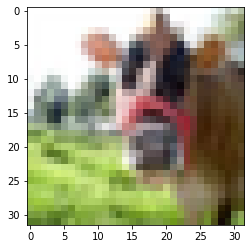

In [97]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [15]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [16]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [17]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [18]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [98]:
plt.imsave("file.png", test_image)

Your new PNG file should now appear in the file explorer.

Now let's just capture all the bicycles and motorcycles and save them. Scones Unlimited can use a model that tells these apart to route delivery drivers automatically.

In the following cell, identify the label numbers for Bicycles and Motorcycles:

In [145]:
import pandas as pd

# Filter the dataset_train and dataset_meta objects to find the label numbers for Bicycle and Motorcycles
print(f"Bicycle label number is {dataset_meta[b'fine_label_names'].index(b'bicycle')}")
print(f"Motorcycle label number is {dataset_meta[b'fine_label_names'].index(b'motorcycle')}")

Bicycle label number is 8
Motorcycle label number is 48


We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data. Below we construct a dataframe, and rows that don't contain observations about bicycles and motorcycles can be safely dropped. 

In [158]:
#Construct the dataframe
df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[(df_train.labels == 8) | (df_train.labels == 48)]

# Decode df_train.filenames so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[(df_test.labels == 8) | (df_test.labels == 48)]

# Decode df_test.filenames so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)

Now that the data is filtered for just our classes, we can save all our images.

In [161]:
!mkdir ./train
!mkdir ./test

In the previous sections we introduced several key snippets of code: grabbing image data, stacking image data into the right shape and saving images.

We compose these together into a function that saves all the images into the `./test` and `./train` directories.

In [102]:
dataset_train[b'data'][0]

array([255, 255, 255, ...,  10,  59,  79], dtype=uint8)

In [162]:
def save_images(dataset, ind, filename, path):
    import os
    #Grab the image data in row-major form
    img = dataset[b'data'][ind]
    
    # Consolidated stacking/reshaping from earlier
    target = np.dstack((
        img[0:1024].reshape(32, 32),
        img[1024:2048].reshape(32, 32),
        img[2048:].reshape(32, 32)
    ))
    
    # Save the image
    plt.imsave(os.path.join(path, filename), target)
    
    # Return any signal data you want for debugging
    return 

df_train.apply(lambda row: save_images(dataset_train, row['row'], row['filenames'], './train'), axis=1)
df_test.apply(lambda row: save_images(dataset_test, row['row'], row['filenames'], './test'), axis=1)

27      None
28      None
116     None
161     None
319     None
        ... 
9654    None
9692    None
9833    None
9928    None
9939    None
Length: 200, dtype: object

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK we grab the current region, execution role, and bucket.

In [3]:
import sagemaker

sess = sagemaker.Session() 

bucket= sess.default_bucket() ## TODO: fill in
print("Default Bucket: {}".format(bucket))

region = sess.boto_region_name ## TODO: fill in
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role() ## TODO: fill in
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-339079465781
AWS Region: us-east-1
RoleArn: arn:aws:iam::339079465781:role/service-role/AmazonSageMaker-ExecutionRole-20211126T100876


With this data we can easily sync your data up into S3!

In [ ]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

Now we can check the bucket and verify that the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [167]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [168]:
import boto3

# Upload files
boto3.Session().resource('s3').Bucket(
    bucket).Object('train.lst').upload_file('./train.lst')
boto3.Session().resource('s3').Bucket(
    bucket).Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model.

In [169]:
# Use the image_uris function to retrieve the latest 'image-classification' image 
algo_image = sagemaker.image_uris.retrieve('image-classification', region=region) 
s3_output_location = f"s3://{bucket}/models/image_model"

We're ready to create an estimator.

In [170]:
img_classifier_model=sagemaker.estimator.Estimator(
    image_uri = algo_image,
    role = role,
    instance_count=1,
    instance_type='ml.p2.xlarge',
    output_path=s3_output_location,
    sagemaker_session= sess
)

We can also set a few key hyperparameters and define the inputs for our model:

In [178]:
img_classifier_model.set_hyperparameters(
    image_shape='3,32,32', 
    num_classes=2, 
    num_training_samples=df_train.shape[0]
)

The `image-classification` image uses four input channels with very specific input parameters.

In [179]:
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs.

In [ ]:
img_classifier_model.fit(
    inputs = model_inputs,
    wait = True,
    job_name = 'project-model-training-v4'
)

If all goes well, we'll end up with a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [183]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, we deploy your model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [184]:
deployment = img_classifier_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

---------------!image-classification-2021-12-21-21-02-36-527


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [186]:
from sagemaker import Predictor
predictor = Predictor(endpoint)

In the code snippet below we are going to prepare one of your saved images for prediction.

In [187]:
from sagemaker.serializers import IdentitySerializer
import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload)

The `inference` object is an array of two values, the predicted probability value for each of our classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [188]:
print(inference)

b'[0.9274435043334961, 0.07255646586418152]'


### Draft Lambdas and Step Function Workflow

The operations team uses Step Functions to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug our workflow into the broader production architecture for Scones Unlimited.

In this next stage we're going to write and deploy three Lambda functions, and then use the Step Functions visual editor to chain them together! Our functions are going to work with a simple data object:

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

A good test object that can be used for Lambda tests and Step Function executions, throughout the next section, might look like this:

```python
{
  "image_data": "",
  "s3_bucket": MY_BUCKET_NAME, # Fill in with your bucket
  "s3_key": "test/bicycle_s_000513.png"
}
```

Using these fields, our functions can read and write the necessary data to execute our workflow. Let's start with the first function. The first Lambda function will copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

We navigate to the Lambda dashboard and create a new Lambda function with a descriptive name like "serializeImageData" and select the 'Python 3.8' runtime. We add the same permissions as the SageMaker role we created earlier. Once you're ready, use the code from lambda_01.py to create Lambda handler:

```python
import json
import boto3
import base64
import urllib

s3 = boto3.client('s3')

def lambda_handler(event, context):
    """A function to serialize target data from S3"""

    # Get the s3 address from the Step Function event input
    key = event['s3_key'] 
    bucket = event['s3_bucket'] 

    # Download the data from s3 to /tmp/image.png
    ## TODO: fill in
    object_name = '/tmp/image.png'
    s3.download_file(bucket, key, object_name)


    # We read the data from a file
    with open("/tmp/image.png", "rb") as f:
        image_data = base64.b64encode(f.read())

    # Pass the data back to the Step Function
    print("Event:", event.keys())
    return {
        'statusCode': 200,
        'body': {
            "image_data": image_data,
            "s3_bucket": bucket,
            "s3_key": key,
            "inferences": []
        }
    }
```

The next function is responsible for the classification part - we're going to take the image output from the previous function, decode it, and then pass inferences back to the the Step Function.

We create a new Lambda function with the same rights and a descriptive name, then fill in then use code from lambda_02.py to create a classifier Lambda.

```python
import json
import base64
import boto3


# Fill this in with the name of your deployed model
ENDPOINT = "image-classification-2021-12-21-21-02-36-527"
runtime = boto3.client('runtime.sagemaker')

def lambda_handler(event, context):

    # Decode the image data
    image = base64.b64decode(event["image_data"])

    # Make a prediction:
    ## TODO: fill in
    response = runtime.invoke_endpoint(
        EndpointName=ENDPOINT,
        ContentType='image/png',
        Body=image)

    # We return the data back to the Step Function   
    inferences = response["Body"].read().decode('utf-8')
    print(inferences)
    return {
        'statusCode': 200,
        'body': {
            "image_data": event['image_data'],
            "s3_bucket": event['s3_bucket'],
            "s3_key": event['s3_key'],
            "inferences": inferences
        }
    }
```

Finally, we need to filter low-confidence inferences. We define a threshold between 1.00 and 0.000 for our model. We make one last Lambda function using lambda_03.py:

```python
import json


THRESHOLD = .90


def lambda_handler(event, context):

    # Grab the inferences from the event
    inferences = json.loads(event['inferences']) 

    
    # Check if any values in our inferences are above THRESHOLD
    meets_threshold = inferences[0] > THRESHOLD or inferences[1] > THRESHOLD 
    
    if inferences[0] > inferences[1]:
        label = "bicycle"
        confidence = inferences[0]
    else:
        label = "motorcycle"
        confidence = inferences[1]

    # If our threshold is met, pass our data back out of the
    # Step Function, else, end the Step Function with an error
    if meets_threshold:
        return {
        'statusCode': 200,
        'body': {
            "prediction": {
                "label": label,
                "confidence": confidence
            } 
        }
    }
    
    else:
        raise Exception("THRESHOLD_CONFIDENCE_NOT_MET")
```

With our lambdas in place, we can use the Step Functions visual editor to construct a workflow that chains them together.

When the visual editor opens, we'll have many options to add transitions in our workflow. We're going to keep it simple and have just one: to invoke Lambda functions. We add three of them chained together. For each one, we'll be able to select the Lambda functions we just created in the proper order, filter inputs and outputs, and give them descriptive names.

We make sure to:

1. Properly filter the inputs and outputs of our invokations (e.g. `$.body`)
2. Take care to remove the error handling from the last function - it's supposed to "fail loudly" for our operations colleagues.

A screenshot of our working step function in action and the step function as JSON are available as part of the package.


Great! Now you can use the files in `./test` as test files for our workflow. Depending on our threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

We perform several step function invokations using data from the `./test` folder. This process should give us confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of our data and inferences which we can visualize.

In [32]:
import random
import boto3
import json


def generate_test_case():
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="test")
    
    # Grab any random object key from that folder!
    obj = random.choice([x.key for x in objects])
    
    return json.dumps({
        "image_data": "",
        "s3_bucket": bucket,
        "s3_key": obj
    })
generate_test_case()

'{"image_data": "", "s3_bucket": "sagemaker-us-east-1-339079465781", "s3_key": "test/cycle_s_000970.png"}'

In the Step Function dashboard for our new function, we can create new executions and copy in the generated test cases. We do several executions so that we can generate data we can evaluate and visualize.

Once we've done several executions, let's visualize the record of our inferences. We pull in the JSONLines data from our inferences like so:

In [33]:
from sagemaker.s3 import S3Downloader

# In S3 your data will be saved to a datetime-aware path
# Find a path related to a datetime you're interested in
data_path = "s3://sagemaker-us-east-1-339079465781/data_capture/fill_in_with_the_right_path"## Fill in the path to your captured data

S3Downloader.download(data_path, "captured_data")

# Feel free to repeat this multiple times and pull in more data

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [35]:
!pip install jsonlines
import jsonlines

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached jsonlines-3.0.0-py3-none-any.whl (8.5 kB)


Now we can extract the data from each of the source files:

In [36]:
import os

# List the file names we downloaded
file_handles = os.listdir("./captured_data")

# Dump all the data into an array
json_data = []
for jsonl in file_handles:
    with jsonlines.open(f"./captured_data/{jsonl}") as f:
        json_data.append(f.read())

The data should now be a list of dictionaries, with significant nesting. The code below grabs data out of the objects and visualizes it:

In [47]:
# Define how we'll get our data
def simple_getter(obj):

    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), timestamp

simple_getter(json_data[0])

([0.6395367980003357, 0.3604632019996643], '2021-12-24T07:31:38Z')

Finally, here's an example of a visualization we can build with this data. The captured data has the input images, the resulting inferences, and the timestamps.

### Visualization


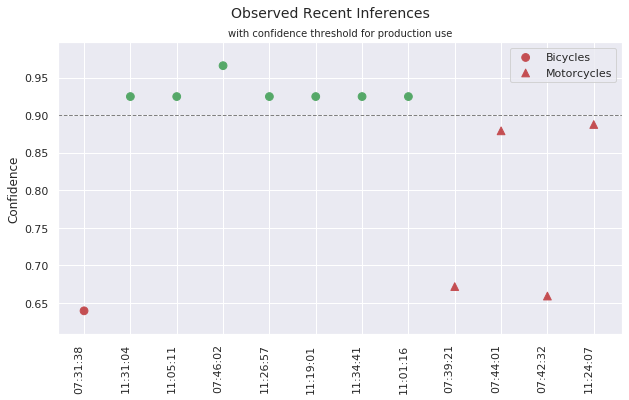

In [179]:
import pandas as pd

sns.set()
plt.rcParams['figure.figsize'] = (9,5)

THRESHOLD = 0.9

#Generate data
x = []
y = []
label = []

for obj in json_data:
    inference, timestamp = simple_getter(obj)
    timestamp = timestamp.split("T")[-1][:-1]
    y.append(max(inference))
    x.append(timestamp)
    
    if inference[0] > inference[1]:
        label.append('bicycle')
    else:
        label.append('motorcycle')

color = ['r' if conf<THRESHOLD else 'g' for conf in y]

data = pd.DataFrame(list(zip(x, y, label, color)),
               columns = ['time', 'confidence', 'label', 'color'])

#Create titles
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("with confidence threshold for production use", size=10)

#Turn xticks
plt.xticks(rotation=90, ha='right')

#Add threshold line
plt.axhline(y=0.9, color='grey', linestyle='--', linewidth=1)

#Plot data wrt to class, confidence and timestamp
plt.scatter(data[data.label=='bicycle']['time'], data[data.label=='bicycle']['confidence'], marker = 'o', s = 60, label='Bicycles', c=data[data.label=='bicycle']['color'])
plt.scatter(data[data.label=='motorcycle']['time'], data[data.label=='motorcycle']['confidence'], marker = '^', s = 60, c=data[data.label=='motorcycle']['color'], label='Motorcycles')
plt.legend(loc='best')

### Summary

In this project we created an event-drivent ML workflow that can be incorporated into the Scones Unlimited production architecture. We used the SageMaker Estimator API to deploy our SageMaker Model and Endpoint, and we used AWS Lambda and Step Functions to orchestrate our ML workflow. Using SageMaker Model Monitor, we instrumented and observed our Endpoint, and at the end of the project we built a visualization to help stakeholders understand the performance of the Endpoint over time. 